# Space Mission Case Study

This case study demonstrates using Pacti for the verification of an autonomous space mission system that uses an onboard planning/scheduling system based on a generalized timeline representation as described in [Chien et al. 2012](#ref1). Examples of such timeline representation modeling include [Rabideau et al. 2017](#ref2) and [Chen et al. 2003](#ref3). Such systems reflect deliberate design decisions to limit the expressiveness of constraint formulas for planning/scheduling due to considerations of the limited computational resources available on space mission systems and performance requirements for computing solutions. In contrast to the general class of 1st order constraint formulas of PDDL (see [Ghallab et al. 1998](#ref4)), such systems involve computationally efficient linear inequalities of the form:

$$aX <= b$$

where $$x$$ is a timeline variable and $$a,b$$ are constants that may encode temporal information about the schedule of a task instance.

Since this class of constraint formula fits the expressiveness of Pacti's polyhedral constraints, this case study explores modeling tasks for an onboard automated planning/scheduling system as assume-guarantee components using Pacti.

## A simple space mission scenario

The following figure illustrates a simplified space mission scenario for a cubesat-sized spacecraft to approach a small body asteroid described in more detail in [Nesnas et al. 2021](ref5). Note: the Sun, Earth, spacecraft and small body asteroid are shown at different scales for illustration purposes.

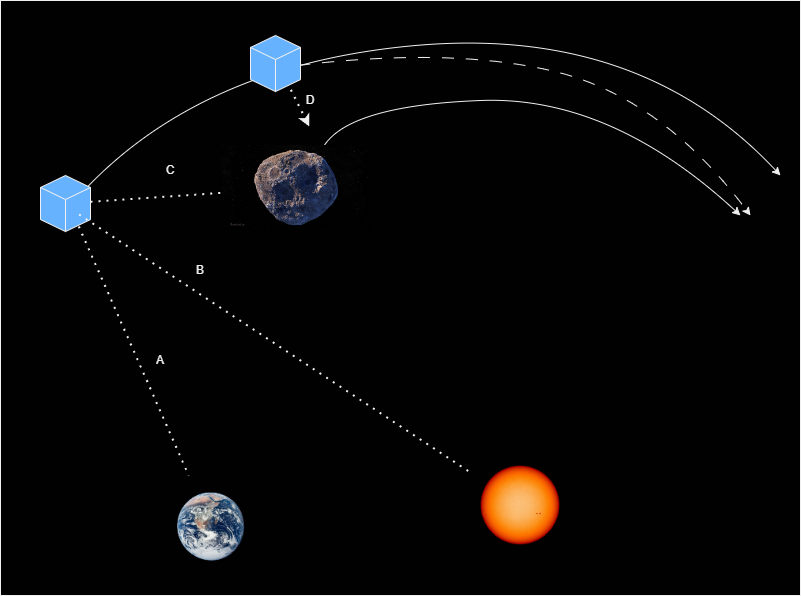


To communicate with Earth, the cubesat-sized spacecraft (blue cube) must orient its fixed antennas towards Earth (line A). Depending on the trajectory, this orientation may be suboptimal for the spacecraft panels to produce maximum electrical power (line B). The spacecraft must make optical measurements of the small body asteroid to estimate its relative trajectory (line C) as part of the onboard autonomous navigation. This navigation requires pointing the spacecraft's thrusters in the direction of a velocity vector (line D) according to a trajectory correction maneuver (TCM). After several carefully designed TCMs, the spacecraft will eventually reach the small body asteroid and land on it as described in [Nesnas et al. 2021](ref5). For onboard planning/scheduling these behaviors would be modeled as tasks in the style of [Rabideau et al. 2017](#ref2) and [Chen et al. 2003](#ref3); that is, tasks would involve linear inequality constraints for specifying their pre/post conditions and their effects. The following describes the specification of these behaviors in Pacti's assume-guarantee paradigm.

### Modeling task behaviors as assume-guarantee contracts

The simplified space mission scenario described above involves the following tasks:

| Task Name | Task Description | Pointing Constraint |
| --------- | ---------------- | ------------------- |
| DSN       | Communicate with Earth | Line A |
| PWR       | Ensure power | Line B |
| SBO       | Acquire Small body observations | Line C |
| TCM       | Perform a Trajectory Correction Maneuver | Line D |

The Pacti specifications for these tasks involve the following variables:

| Variable name | Value range | Variable description |
| ------------- | ----------- | -------------------- |
| `t` | $[0-..]$ | time |
| `soc` | $[0-100]$ | Spacecraft's battery state-of-charge |
| `d` | $[0-100]$ | Spacecraft's onboard science data from small body observations |
| `e` | $[0-100]$ | Spacecraft's estimation of its small-body relative trajectory error |
| `r` | $[0-100]$ | Spacecraft's relative distance (100=trajectory at beginning of scenario, 0=trajectory at rendez-vous with small body) |

These variables appear as inputs and outputs of Pacti component specifications as illustrated below for two components, `A` and `B` where the temporal ordering of the schedule of `B` starting after the end of the schedule of `A` corresponds to the composition of `A` and `B` in Pacti.

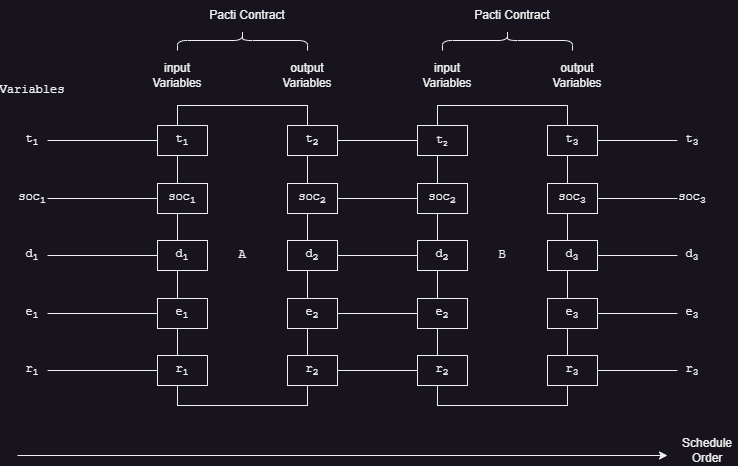

In [1]:
from pacti.terms.polyhedra import *
from pacti.iocontract import IoContract, Var
from PIL import Image
import matplotlib.pyplot as plt
import os
import numpy as np
from matplotlib import patches
import pdb
from matplotlib.collections import PatchCollection
from contract_utils import connect

varPrefixes=["t", "soc", "d", "e", "r"]

#### Initial scenario conditions

In [2]:
def initial_contract() -> tuple[int, PolyhedralContract]:
  e=1
  spec = PolyhedralContract.from_string(
    InputVars = [],
    OutputVars= [
      f"t{e}",    # Scheduled end time
      f"soc{e}",  # final battery SOC
      f"d{e}",    # final data volume
      f"e{e}",    # final trajectory error
      f"r{e}",    # final relative distance
    ],
    assumptions=[],
    guarantees=[
      f"t{e} = 0",
      f"-soc{e} <= -100",
      f"-d{e} <= 0",
      f"-e{e} <= 0",
      f"-r{e} <= -100",
    ]
  )
  return e, spec

#### DSN Task (Communicate with Earth)

In [3]:
# DSN:
# Parameters:
# - s: start index of the timeline variables
# - duration: scheduled task instance duration
# - consumption: rate of battery discharge during the task instance
def DSN_contract(s: int, duration: float, consumption: float) -> tuple[int, PolyhedralContract]:
  e = s+1
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"t{s}",    # Scheduled start time
      f"soc{s}",  # initial battery SOC
      f"d{s}",    # initial data volume
      f"e{s}",    # initial trajectory error
      f"r{s}",    # initial relative distance
    ],
    OutputVars = [
      f"t{e}",    # Scheduled end time
      f"soc{e}",  # final battery SOC
      f"d{e}",    # final data volume
      f"e{e}",    # final trajectory error
      f"r{e}",    # final relative distance
    ],
    assumptions = [
      # Battery has enough energy for the consumption over the duration of the task instance
      f"-soc{s} <= -{duration*consumption}",

      # There is some science data to downlink
      f"-d{s} <= -1"
    ],
    guarantees = [
      # Scheduled task instance end time
      f"t{e} - t{s} = {duration}",

      # Battery discharges by at most duration*consumption
      f"soc{s} - soc{e} <= {duration*consumption}",

      # All science data has been downlinked by the end of the task
      f"d{e} = 0",

      # no change to trajectory error
      f"e{e} - e{s} = 0",

      # no change to relative distance
      f"r{e} - r{s} = 0",
    ])
  return e, spec

#### PWR Task (Ensure power)

In [4]:
# PWR:
# Parameters:
# - s: start index of the timeline variables
# - duration: scheduled task instance duration
# - generation: rate of battery charge during the task instance
def PWR_contract(s: int, duration: float, generation: float) -> tuple[int, PolyhedralContract]:
  e = s+1
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"t{s}",    # Scheduled start time
      f"soc{s}",  # initial battery SOC
      f"d{s}",    # initial data volume
      f"e{s}",    # initial trajectory error
      f"r{s}",    # initial relative distance
    ],
    OutputVars = [
      f"t{e}",    # Scheduled end time
      f"soc{e}",  # final battery SOC
      f"d{e}",    # final data volume
      f"e{e}",    # final trajectory error
      f"r{e}",    # final relative distance
    ],
    assumptions = [
      # There is energy left in the battery
      f"-soc{s} <= 0",
    ],
    guarantees = [
      # Scheduled task instance end time
      f"t{e} - t{s} = {duration}",
    
      # Battery charges by at least duration*consumption
      f"-soc{e} + soc{s} <= -{duration*generation}",

      # no change to data volume
      f"d{e} - d{s} = 0",

      # no change to trajectory error
      f"e{e} - e{s} = 0",

      # no change to relative distance
      f"r{e} - r{s} = 0",
    ])
  return e, spec

#### SBO Task (Small body observations)

In [5]:
# SBO:
# Parameters:
# - s: start index of the timeline variables
# - duration: scheduled task instance duration
# - generation: rate of small body observations during the task instance
# - consumption: rate of battery discharge during the task instance
# - improvement: rate of trajectory error improvement during the task instance
def SBO_contract(s: int, duration: float, generation: float, consumption: float, improvement: float) -> tuple[int, PolyhedralContract]:
  e = s+1
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"t{s}",    # Scheduled start time
      f"soc{s}",  # initial battery SOC
      f"d{s}",    # initial data volume
      f"e{s}",    # initial trajectory error
      f"r{s}",    # initial relative distance
    ],
    OutputVars = [
      f"t{e}",    # Scheduled end time
      f"soc{e}",  # final battery SOC
      f"d{e}",    # final data volume
      f"e{e}",    # final trajectory error
      f"r{e}",    # final relative distance
    ],
    assumptions = [
      # Battery has enough energy for the consumption over the duration of the task instance
      f"-soc{s} <= -{duration*consumption}",
    ],
    guarantees = [
      # Scheduled task instance end time
      f"t{e} - t{s} = {duration}",
    
      # Battery discharges by at most duration*consumption
      f"soc{s} - soc{e} <= {duration*consumption}",

      # data volume increases by at least duration*generation
      f"d{s} - d{e} <= -{duration*generation}",

      # trajectory error improves by at least duration*improvement
      f"e{s} - e{e} <= -{duration*improvement}",

      # no change to relative distance
      f"r{e} - r{s} = 0",
    ])
  return e, spec

#### TCM Task (Perform a Trajectory Correction Maneuver)

In [6]:
# TCM:
# Parameters:
# - s: start index of the timeline variables
# - duration: scheduled task instance duration
# - max_error: maximum relative trajectory error before the task instance
# - heating_cost: total battery discharge due to the heating required before the TCM
# - delta: relative trajectory improvement as a result of the delta-V thrust performed in this task instance
def TCM_contract(s: int, duration: float, max_error: float, heating_cost: float, delta: float) -> tuple[int, PolyhedralContract]:
  e = s+1
  spec = PolyhedralContract.from_string(
    InputVars = [
      f"t{s}",    # Scheduled start time
      f"soc{s}",  # initial battery SOC
      f"d{s}",    # initial data volume
      f"e{s}",    # initial trajectory error
      f"r{s}",    # initial relative distance
    ],
    OutputVars = [
      f"t{e}",    # Scheduled end time
      f"soc{e}",  # final battery SOC
      f"d{e}",    # final data volume
      f"e{e}",    # final trajectory error
      f"r{e}",    # final relative distance
    ],
    assumptions = [
      # Battery SOC has enough to perform the heating
      f"-soc{s} <= -{heating_cost}",

      # Max trajectory error
      f"e{s} <= {max_error}",
    ],
    guarantees = [
      # Scheduled task instance end time
      f"t{e} - t{s} = {duration}",

      # Battery discharges by at most heating_cost
      f"soc{s} - soc{e} <= {heating_cost}",

      # no change to data volume
      f"d{e} - d{s} = 0",
      
      # no change to trajectory error
      f"e{e} - e{s} = 0",

      # trajectory improves by at least delta
      f"r{s} - r{e} <= -{delta}",
    ])
  return e, spec

### Schedule examples

In [7]:
s1,init=initial_contract()
print("Contract init:")
print(init)


Contract init:
InVars: []
OutVars:[t1, soc1, d1, e1, r1]
A: [
]
G: [
  t1 = 0.0
  -soc1 <= -100.0
  -d1 <= 0.0
  -e1 <= 0.0
  -r1 <= -100.0
]


In [13]:
s2,dsn1 = DSN_contract(s=10, duration=2.0, consumption=3.0)
print("Contract dsn1:")
print(dsn1)

plot_guarantees(contract=dsn1,
                x_var=Var("t10"),
                y_var=Var("soc11"),
                var_values={
                  Var("t10"):0,
                  Var("t11"):2,
                  Var("d10"):1,
                  Var("d11"):0,
                  Var("e10"):0,
                  Var("e11"):0,
                  Var("r10"):0,
                  Var("r11"):0,
                  Var("soc10"):6,
                },
                x_lims=(-2,2),
                y_lims=(-2,2))

Contract dsn1:
InVars: [t10, soc10, d10, e10, r10]
OutVars:[t11, soc11, d11, e11, r11]
A: [
  -soc10 <= -6.0
  -d10 <= -1.0
]
G: [
  -t10 + t11 = 2.0
  soc10 - soc11 <= 6.0
  d11 = 0.0
  -e10 + e11 = 0.0
  -r10 + r11 = 0.0
]


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 3

In [ ]:
s3,pwr1 = PWR_contract(s=20, duration=2.0, generation=20.0)
print("Contract pwr1:")
print(pwr1)

In [ ]:
s4,sbo1 = SBO_contract(s=30, duration=6.0, generation=10.0, consumption=4.0, improvement=8.0)
print("Contract sbo1:")
print(sbo1)

In [ ]:
s5,tcm1 = TCM_contract(s=40, duration=1.0, max_error=4.0, heating_cost=40.0, delta=5.0)
print("Contract tcm1:")
print(tcm1)

In [ ]:
# This composition is well-formed; however, the variables are disjoint!
c0a = init.compose(sbo1)
print("Contract c0a = init.compose(sbo1):")
print(c0a)

In [ ]:
# Correct composition with a contract connector
c0b = connect(init, sbo1, varPrefixes)
print("Contract c0b = connect(init, sbo1, varPrefixes):")
print(c0b)

#### Creating the schedule of task instances by composing the task instance contracts (the compositions below are all wrong because the variables are disjoint!)

To compose contracts, we need to generate composable input/ouput variables.

In [ ]:
c1 = dsn1.compose(pwr1)
print("Contract dsn1.compose(pwr1):")
print(c1)

In [ ]:
c2 = c1.compose(sbo1)
print("Contract c1.compose(sbo1):")
print(c2)

In [ ]:
c3 = c2.compose(tcm1)
print("Contract c2.compose(tcm1):")
print(c3)

## References

<a id="ref1"></a> __[Chien et al. 2012](https://ai.jpl.nasa.gov/public/documents/papers/chien_spaceops2012_generalized.pdf)__

Chien, S.; Johnston, M.; Policella, N.; Frank, J.; Lenzen, C.; Giuliano, M.; and Kavelaars, A. 
**A generalized timeline representation, services, and interface for automating space mission operations.** 
In International Conference On Space Operations (SpaceOps 2012), Stockholm, Sweden, June 2012. 

<a id="ref2"></a> __[Rabideau et al. 2017](https://arc.aiaa.org/doi/pdf/10.2514/1.I010544)__

Rabideau, G.; Chien, S.; Galer, M.; Nespoli, F.; and Costa, M. 
**Managing Spacecraft Memory Buffers with Concurrent Data Collection and Downlink.** 
Journal of Aerospace Information Systems (JAIS). December 2017.

<a id="ref3"></a> __[Chen et al. 2003](https://www.researchgate.net/profile/Benjamin-Wah/publication/2861650_Automated_Planning_and_Scheduling_using_Calculus_of_Variations/links/54db35b20cf261ce15cf7)__

Chen, Y. and Wah, B. 
**Automated Planning and Scheduling using Calculus of Variations.**
13th International Conference on Automated Planning&Scheduling (ICAPS 2003), Trento, Italy, June 2003.

<a id="ref4"></a> __[Ghallab et al. 1998](https://planning.wiki/_citedpapers/pddl1998.pdf)__

Ghallab, M., Knoblock, C., Wilkins, D., Barrett, A., Christianson, D., Friedman, M., Kwok, C., Golden, K., Penberthy, S., Smith, D., Sun, Y., & Weld, D. (1998). 
**PDDL - The Planning Domain Definition Language.**

<a id="ref5"></a> __[Nesnas et al. 2021](https://www.frontiersin.org/articles/10.3389/frobt.2021.650885/full)__

Nesnas, I. A. D., Hockman, B. J., Bandopadhyay, S., Morrell, B. J., Lubey, D. P., Villa, J., Bayard, D. S., Osmundson, A., Jarvis, B., Bersani, M., Bhaskaran, S.
**Autonomous Exploration of Small Bodies Toward Greater Autonomy for Deep Space Missions**
In Frontiers in Robotics and AI, volume 8, November 2021.